# Machine Learning Tabular Binary

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import random as rd
from matplotlib.ticker import FormatStrFormatter
from collections import defaultdict
import re
import string

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn.ensemble import StackingClassifier

from scipy.stats import uniform, loguniform, randint

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, Activation, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Flatten, concatenate, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.layers import Layer

import transformers

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

import gc

In [3]:
from script_preprocessing_tabular import *

In [4]:
data = pd.read_csv('../input/predicting-churn-for-bank-customers/Churn_Modelling.csv')
data = data.iloc[:,3:]
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


# Metrics

In [5]:
# help function

def calcul_metric_binary(y_true_, y_pred, print_results):
    try: # try to pass y_true_ to type numpy
        y_true = y_true_.values.copy()
    except:
        y_true = y_true_.copy()
        
    report = classification_report(y_true.reshape(-1), np.where(y_pred<0.5,0,1).reshape(-1), digits = 4, output_dict = True)
    acc = np.round(report['accuracy'],4)
    f1 = np.round(report['1']['f1-score'],4)
    recall = np.round(report['1']['recall'],4)
    precision = np.round(report['1']['precision'],4)
    #roc_auc = np.round(roc_auc_score(y_true.values, np.where(y_pred<0.5,0,1)),4)
    fp_rate, tp_rate, thresholds = roc_curve(y_true.reshape(-1), y_pred.reshape(-1))
    roc_auc = np.round(auc(fp_rate, tp_rate),4)
    
    if print_results:
        print('\nCross validation score :')
        print()
        print('roc_auc =', roc_auc)
        print('precision 1 =', precision)
        print('recall 1 =', recall)
        print('f1 score 1 =',f1)
        print()
        print(classification_report(y_true.reshape(-1), np.where(y_pred<0.5,0,1).reshape(-1), digits = 3))
    
    return acc, f1, recall, precision, roc_auc

def roc(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    return fpr, tpr

# Help functions and GridSearch functions

In [6]:
def compute_dict_class_weight(y, class_weight, objective):
    if class_weight == "balanced":
        if ('binary' in objective) or (y.shape[1] == 1 and 'classification' in objective):
            weights = compute_class_weight(class_weight='balanced', classes=np.unique(y.reshape(-1)), y=y.reshape(-1))
            return dict(zip(np.unique(y.reshape(-1)), weights))
        else:
            return None
    else:
        return None


def optimization_gridsearch(x, y, model, distributions, time_limit_per_model, nfolds, scoring, objective):
    """ gridsearch function for sklearn model with time integrated """
    
    print_details = False
    
    n_iter = 1
    
    start, last_call = time.perf_counter(), time.perf_counter()

    df_results = pd.DataFrame()
    df_all_results = pd.DataFrame()
    best_n_iter = 0

    while time.perf_counter() - start < time_limit_per_model:

        clf = RandomizedSearchCV(model, distributions, random_state=None, n_iter = n_iter, cv = nfolds, scoring = scoring)
        search = clf.fit(x, y)

        approx_time = (time.perf_counter() - last_call) / n_iter
        if print_details:
            print('time :', approx_time * n_iter,'and n_iter :', n_iter)
            print(search.best_params_)
            print(search.best_score_)
            print()
        if n_iter > best_n_iter:
            best_approx_time = approx_time
            best_n_iter = n_iter

        n_iter = int( (time_limit_per_model - (time.perf_counter() - start)) / best_approx_time / 3 )
        last_call = time.perf_counter()

        df_results = pd.concat([df_results, pd.DataFrame(clf.cv_results_)], axis=0).reset_index(drop=True)

        if n_iter < 3 and time.perf_counter() - start > time_limit_per_model * 0.8:
            break
            
        if n_iter < 1:
            break
            
    print('  Total time :', np.round(time.perf_counter() - start, 3), 'and n_iter :',len(df_results))

    df_all_results = pd.concat([df_all_results, df_results])

    best_mean = np.mean(df_results.mean_test_score)
    best_score = np.max(df_results.mean_test_score)
    if print_details:
        plt.hist(df_results.mean_test_score)
        plt.show()        
        
    return df_all_results


class GridSearch:
    
    def __init__(self, model, hyper_params):
        self.model = model
        self.model_2 = model
        self.hyper_params = hyper_params
        
    def train(self, x, y, nfolds = 5, scoring = 'accuracy', verbose = 0, time_limit_per_model = 60, objective = 'binary'):
        self.df_all_results = optimization_gridsearch(x, y, self.model, self.hyper_params, time_limit_per_model, nfolds, scoring, objective)
        self.index_best_score = self.df_all_results.mean_test_score.argmax()
        
    def show_distribution_score(self):
        plt.hist(self.df_all_results.mean_test_score)
        plt.show()
    
    def best_params(self, print_result = False):
        params = self.df_all_results.loc[self.index_best_score,'params']
        print_params = params.copy()
        if print_result:
            if 'vect__text__tfidf__stop_words' in params.keys() and params['vect__text__tfidf__stop_words'] is not None:
                print_params['vect__text__tfidf__stop_words'] = True
            if 'vect__tfidf__stop_words' in params.keys() and params['vect__tfidf__stop_words'] is not None:
                print_params['vect__tfidf__stop_words'] = True  
            print('Best parameters: ', print_params)
        return params
    
    def best_score(self, print_result = False):
        score = self.df_all_results.loc[self.index_best_score,'mean_test_score']
        if print_result:
            print('Mean cross-validated score of the best_estimator: ', np.round(score,4))
        return score
    
    def best_estimator(self, objective):
        if 'catboost' in str(type(self.model_2)):
            return cat.CatBoostClassifier(
                                           random_state = self.model_2.get_param('random_state'),
                                           class_weights = self.model_2.get_param('class_weights'),
                                           verbose=False,
                                           bootstrap_type='Bernoulli',
                                           **self.best_params()
                                                         )
        else:
            return self.model_2.set_params(**self.best_params())
    
    def get_grid(self, sort_by = 'mean_test_score'):
        return self.df_all_results[['mean_fit_time', 'params', 'mean_test_score', 'std_test_score']].sort_values(by = sort_by, ascending=False).reset_index(drop=True)
    
    

class GridSearch_NN:
    
    def __init__(self, Model_NN, hyper_params):
        self.Model_NN = Model_NN
        self.hyper_params = hyper_params
        
    def optimise(self, params):
        
        self.Model_NN.initialize_params(self.x, self.y, params)
        
        print(self.Model_NN.p)
        
        oof_val = np.zeros((self.y.shape[0],self.y.shape[1]))
        start = time.perf_counter()
        
        for n, (tr, te) in enumerate(KFold(n_splits = self.nfolds, 
                                           random_state = self.Model_NN.seed, 
                                           shuffle = True).split(self.y)):
            
            if isinstance(self.x,dict):
                x_tr, x_val = {}, {}
                for col in self.x.keys():
                    x_tr[col], x_val[col] = self.x[col][tr], self.x[col][te]
                y_tr, y_val = self.y.values[tr], self.y.values[te]
            else:
                x_tr, x_val = self.x.values[tr], self.x.values[te]
                y_tr, y_val = self.y.values[tr], self.y.values[te]


            model = self.Model_NN.model()
            
            if self.scoring == 'accuracy':
                monitor = 'accuracy'
            else:
                monitor = 'loss'
                
            rlr = ReduceLROnPlateau(monitor = 'val_'+monitor, factor = 0.1, patience = 3, 
                                    verbose = 0, epsilon = 1e-4, mode = 'auto', min_lr = 1e-4)

            #ckp = ModelCheckpoint(f'model_{n}.hdf5', monitor = 'val_loss', verbose = 0, 
            #                      save_best_only = True, save_weights_only = True, mode = 'min')

            es = EarlyStopping(monitor = 'val_'+monitor, min_delta = 0.0001, patience = 4, mode = 'auto', 
                               baseline = None, restore_best_weights = True, verbose = 0)

            history = model.fit(x_tr, y_tr, validation_data = (x_val, y_val), 
                                epochs = 60, batch_size = 16, class_weight = compute_dict_class_weight(y_tr, self.Model_NN.class_weight, self.Model_NN.objective),
                                callbacks = [rlr, es], verbose = 0)

            hist = pd.DataFrame(history.history)
            
            if 'binary_proba' in self.Model_NN.objective:
                oof_val[te,:] = model.predict(x_val)
            else:
                oof_val[te,:] = np.argmax(model.predict(x_val),axis=1).reshape(-1,1)
                        
            self.total_epochs += len(history.history['val_loss'][:-5])
            
            K.clear_session()
            del model, history, hist
            d = gc.collect()
             
        metrics = []
        oof_val = np.where(oof_val>0.5,1,0).reshape(-1)
        if 'f1' in self.scoring:
            metrics.append(-f1_score(self.y.values.reshape(-1), oof_val))
        elif 'recall' in self.scoring:
            metrics.append(-recall_score(self.y.values.reshape(-1), oof_val))
        elif 'precision' in self.scoring:
            metrics.append(-precision_score(self.y.values.reshape(-1), oof_val))
        elif 'roc' in self.scoring or 'auc' in self.scoring:
            metrics.append(-roc_auc_score(self.y.values.reshape(-1), oof_val))
        else:
            metrics.append(-accuracy_score(self.y.values.reshape(-1), oof_val))
                
        score = -np.mean(metrics)
        print('oof_val score',self.scoring,'Metric', score)
        
        if 'hidden_units' in self.Model_NN.p.keys():
            self.list_hist[len(self.Model_NN.p['hidden_units']) - 1].append(score)
        else:
            self.list_hist[0].append(score)
        self.df_all_results['mean_fit_time'].append(time.perf_counter() - start)
        self.df_all_results['params'].append(params)
        self.df_all_results['mean_test_score'].append(score)
        self.df_all_results['std_test_score'].append(0) #just 0
        
        return np.mean(metrics)

    def train(self, x_, y_, nfolds = 5, scoring = 'accuracy', verbose = 0, time_limit_per_model = 60, name_model = 'SimpleNeuralNetwork'):
        self.x = x_#.copy().reset_index(drop=True)
        self.y = y_#.copy().reset_index(drop=True)
        self.nfolds = nfolds
        self.scoring = scoring
        self.df_all_results = {'mean_fit_time':[], 'params':[], 'mean_test_score':[], 'std_test_score':[]}
        self.list_hist = [[] for name in self.hyper_params.keys() if 'hidden_unit' in name]
        if len(self.list_hist) == 0:
            self.list_hist = [[]]
        self.total_epochs = 0
        trials = Trials()
        
        self.hopt = fmin(fn = self.optimise, 
                    space = self.hyper_params, 
                    algo = tpe.suggest, 
                    max_evals = 100, 
                    timeout = time_limit_per_model, 
                    trials = trials, 
                   )

        self.df_all_results = pd.DataFrame(self.df_all_results)
        self.df_all_results['model'] = name_model
        self.index_best_score = self.df_all_results.mean_test_score.argmax()
        self.mean_epochs = int(self.total_epochs/self.nfolds) + 1
        
    def show_distribution_score(self):
        rows, cols = 1, 3
        fig, ax = plt.subplots(rows, cols, figsize=(50,20))

        for row in range(rows):
            for col in range(cols):
                if row * cols + col + 1 <= len(self.list_hist) and len(self.list_hist[row * cols + col]) > 0:
                    ax[col].hist(self.list_hist[row * cols + col])
                    for tick in ax[col].xaxis.get_major_ticks():
                        tick.label.set_fontsize(30)
        plt.show()
    
    def best_params(self, print_result = False):
        params = self.df_all_results.loc[self.index_best_score,'params']
        if print_result:
            print('Best parameters: ', params)
        return params
    
    def best_score(self, print_result = False):
        score = self.df_all_results.loc[self.index_best_score,'mean_test_score']
        if print_result:
            print('Mean cross-validated score of the best_estimator: ', np.round(score,4))
        return score
    
    def best_estimator(self, objective):
        self.Model_NN.initialize_params(self.x, self.y, self.best_params())
        
        model = self.Model_NN.model()
        
        if self.scoring == 'accuracy':
            monitor = 'accuracy'
        else:
            monitor = 'loss'
        rlr = ReduceLROnPlateau(monitor='val_'+monitor, factor = 0.1, patience = 3, 
                                    verbose = 1, epsilon = 1e-4, mode = 'auto', min_lr = 1e-4)

        #ckp = ModelCheckpoint(f'model_{n}.hdf5', monitor = 'val_loss', verbose = 0, 
        #                      save_best_only = True, save_weights_only = True, mode = 'min')

        es = EarlyStopping(monitor = 'val_'+monitor, min_delta = 0.0001, patience = 5, mode = 'auto', 
                               baseline = None, restore_best_weights = True, verbose = 0)
        
        for n, (tr, te) in enumerate(KFold(n_splits = 10, 
                                           random_state = self.Model_NN.seed, 
                                           shuffle = True).split(self.y)):
            
            if isinstance(self.x,dict):
                x_tr, x_val = {}, {}
                for col in self.x.keys():
                    x_tr[col], x_val[col] = self.x[col][tr], self.x[col][te]
                y_tr, y_val = self.y.values[tr], self.y.values[te]
            else:     
                x_tr, x_val = self.x.values[tr], self.x.values[te]
                y_tr, y_val = self.y.values[tr], self.y.values[te]
            
            history = model.fit(x_tr, y_tr, validation_data = (x_val, y_val), 
                                epochs = 60, batch_size = 16, class_weight = compute_dict_class_weight(y_tr, self.Model_NN.class_weight, self.Model_NN.objective),
                                callbacks = [rlr, es], verbose = 0)
            break #best_model train on only one validation
        return model
    
    def get_grid(self, sort_by = 'mean_test_score'):
        return self.df_all_results[['mean_fit_time', 'params', 'mean_test_score', 'std_test_score']].sort_values(by = sort_by, ascending=False).reset_index(drop=True)

# Validation

In [7]:
class Validation:
    
    def __init__(self, objective, seed = 15, is_NN = False, name = None, class_weight = None):
        self.seed = seed
        self.objective = objective
        self.is_NN = is_NN
        self.name = name
        self.class_weight = class_weight
        
    def fit(self, model, x, y, nfolds = 5, scoring = 'accuracy', print_result = False):
        
        self.oof_val = np.zeros((len(y),))
        self.fold_id = np.zeros((len(y),))
        
        if self.is_NN:
            #weights = model.get_weights()
            #model.save_weights('model.h5')
            total_epochs = 0
            
            kf = KFold(n_splits = nfolds, shuffle = True, random_state = self.seed)

            for num_fold ,(train_index, val_index) in enumerate(kf.split(y)):
                if isinstance(x,dict):
                    x_train, x_val = {}, {}
                    for col in x.keys():
                        x_train[col], x_val[col] = x[col][train_index], x[col][val_index]
                    y_train, y_val = y.values[train_index], y.values[val_index]
                else:
                    try:
                        x_train,x_val = x.values[train_index], x.values[val_index]
                    except:
                        x_train,x_val = x[train_index], x[val_index]
                    try:
                        y_train,y_val = y.values[train_index], y.values[val_index]
                    except:
                        y_train,y_val = y[train_index], y[val_index]
                    
                K.clear_session()
                #model = model.set_weights(weights)
                #model.load_weights('model.h5')
                    
                model_nn = model()
                    
                if scoring == 'accuracy':
                    monitor = 'accuracy'
                else:
                    monitor = 'loss'
                rlr = ReduceLROnPlateau(monitor='val_'+monitor, factor = 0.1, patience = 3,
                                    verbose = 1, epsilon = 1e-4, mode = 'auto', min_lr = 1e-4)   ########## !!!!!!!!!!!!

                #ckp = ModelCheckpoint(f'model_{n}.hdf5', monitor = 'val_loss', verbose = 0,
                #                      save_best_only = True, save_weights_only = True, mode = 'min')

                es = EarlyStopping(monitor = 'val_'+monitor, min_delta = 0.0001, patience = 4, mode = 'auto', 
                                       baseline = None, restore_best_weights = True, verbose = 0)
                    
                train_history = model_nn.fit(x_train, y_train,
                              validation_data = (x_val, y_val), class_weight = compute_dict_class_weight(y_train, self.class_weight, self.objective),
                              epochs=50, batch_size=16, verbose=1, callbacks = [rlr, es])
                
                print('Kfold #',num_fold,' : train',monitor,'=',train_history.history[monitor][-5],' and val',monitor,'=',train_history.history['val_'+monitor][-5])
                total_epochs += len(train_history.history[monitor][:-5])
                    
                if 'binary_proba' in self.objective:
                    self.oof_val[val_index] = model_nn.predict(x_val).reshape(-1)
                else:
                    self.oof_val[val_index] = np.argmax(model_nn.predict(x_val),axis=1).reshape(-1)
                self.fold_id[val_index] = num_fold

        else:
            kf = KFold(n_splits = nfolds, shuffle = True, random_state = self.seed)

            for num_fold ,(train_index, val_index) in enumerate(kf.split(x)):
                try:
                    x_train,x_val = x.values[train_index], x.values[val_index]
                except:
                    x_train,x_val = x[train_index], x[val_index]
                try:
                    y_train,y_val = y.values[train_index], y.values[val_index]
                except:
                    y_train,y_val = y[train_index], y[val_index]

                model.fit(x_train, y_train)

                if 'binary_proba' in self.objective:
                    self.oof_val[val_index] = model.predict_proba(x_val)[:,1].reshape(x_val.shape[0],)
                else:
                    self.oof_val[val_index] = model.predict(x_val).reshape(x_val.shape[0],)
                self.fold_id[val_index] = num_fold

        self.acc_val, self.f1_val, self.recall_val, self.pre_val, self.roc_auc_val = calcul_metric_binary(y, self.oof_val, print_result)
        self.fpr, self.tpr = roc(y.values, self.oof_val)
        
        del x_train, x_val, y_train, y_val, model
        
    def get_cv_prediction(self):
        return self.fold_id, self.oof_val
    
    def get_scores(self):
        return self.acc_val, self.f1_val, self.recall_val, self.pre_val, self.roc_auc_val
    
    def get_roc(self):
        return self.fpr, self.tpr

# Prediction

In [8]:
class Prediction:
    
    def __init__(self, objective, name = None, is_NN = False, class_weight = None):
        self.objective = objective
        self.name = name
        self.is_NN = is_NN
        self.class_weight = class_weight
    
    def fit(self, model, x, y = None, print_result = False):
        
        if self.is_NN:
            if 'pandas' in str(type(x)):
                self.prediction = model.predict(x.values)
            else:
                self.prediction = model.predict(x)
        else:
            if self.objective == 'binary_proba':
                if 'pandas' in str(type(x)):
                    self.prediction = model.predict_proba(x.values)[:,1]
                else:
                    self.prediction = model.predict_proba(x)[:,1]
            else:
                if 'pandas' in str(type(x)):
                    self.prediction = model.predict(x.values)
                else:
                    self.prediction = model.predict(x)
        
        if y is not None: 
            if self.objective == 'binary' and self.is_NN:
                self.prediction = np.argmax(self.prediction,axis=1).reshape(-1)
            else:
                self.prediction = self.prediction.reshape(-1)
            self.acc_test, self.f1_test, self.recall_test, self.pre_test, self.roc_auc_test =  calcul_metric_binary(y, self.prediction, print_result)

    def get_prediction(self):
        return self.prediction
    
    def get_scores(self):
        return self.acc_test, self.f1_test, self.recall_test, self.pre_test, self.roc_auc_test

# BinaryML

In [9]:
class BinaryML:
    
    def __init__(self, exclude_model = [], max_nb_model = None, max_run_time = None, max_run_time_per_modele = 60, early_stopping = False, objective = 'binary',
                 nfolds = 5, keep_cv_pred =True, seed = 15, class_weight = False, print_result = False, scoring = "accuracy", verbose = 0,
                size_params = 'small', apply_stacking = False, apply_blend_model = False, method_scaling = "MinMaxScaler", method_embedding = {}):
        self.exclude_model = exclude_model
        self.max_nb_model = max_nb_model
        self.max_run_time = max_run_time
        self.max_run_time_per_modele = max_run_time_per_modele
        self.early_stopping = early_stopping
        self.nfolds = nfolds
        self.keep_cv_pred = keep_cv_pred
        self.seed = seed
        if not class_weight:
            self.class_weight = None
        else:
            self.class_weight = "balanced"
        self.print_result = print_result
        self.scoring = scoring
        self.verbose = verbose
        self.objective = objective
        self.size_params = size_params
        self.apply_stacking = apply_stacking
        self.apply_blend_model = apply_blend_model
        self.method_scaling = method_scaling
        self.info_scores = {}
        
        self.method_embedding = method_embedding
        
    def split_data(self, frac = 0.8):
        train_data = self.data.sample(frac=frac, random_state=self.seed)
        self.X_train = train_data.copy()
        self.Y_train = self.Y.loc[train_data.index,:]
        if self.doc_spacy_data is not None:
            self.doc_spacy_data_train = np.array(self.doc_spacy_data)[list(train_data.index)]
        else:
            self.doc_spacy_data_train = None
        
        if frac < 1:
            test_data = self.data.drop(train_data.index)
            self.X_test = test_data.copy()
            self.Y_test = self.Y.drop(train_data.index)
            if self.doc_spacy_data is not None:
                self.doc_spacy_data_test = np.array(self.doc_spacy_data)[[i for i in range(len(self.doc_spacy_data)) if i not in list(train_data.index)]]
            else:
                self.doc_spacy_data_test = None
        
    def normalize_data(self):
        self.features = self.X_train.columns.values
        if self.method_scaling == 'MinMaxScaler':
            self.scaler = MinMaxScaler(feature_range = (0,1)) # or (-1,1)
        elif self.method_scaling == 'RobustScaler':
            self.scaler = RobustScaler()
        else:
            self.scaler = StandardScaler()
        
        self.features = list(self.X_train.columns)
        self.scaler.fit(self.X_train)

        self.X_train[self.features] = self.scaler.transform(self.X_train[self.features])
        try:
            self.X_test[self.features] = self.scaler.transform(self.X_test[self.features])
        except:
            pass

        
    def data_preprocessing(self, data, target = None, column_text = None,
                           frac = 0.8, normalize = True, remove_multicollinearity = False, feature_selection = False, subsample = 1,
                           info_pca = {}, info_tsne = {}, info_stats = {}, remove_low_variance = False,
                           remove_percentage = 0.8, multicollinearity_threshold = 0.9, feature_selection_threshold = 0.8,
                           method_nan_categorical = 'constant', method_nan_numeric = 'mean',
                           apply_small_clean = False):
        
        if not 'text' in self.objective:
            self.pre = Preprocessing(data, target, None)
            self.data = self.pre.fit_transform(remove_multicollinearity = remove_multicollinearity, feature_selection = feature_selection,
                                     class_weight = self.class_weight, subsample = subsample,info_stats = info_stats, remove_low_variance = remove_low_variance,
                                     remove_percentage = remove_percentage, multicollinearity_threshold = multicollinearity_threshold,
                                     feature_selection_threshold = feature_selection_threshold,
                                     method_nan_categorical = method_nan_categorical, method_nan_numeric = method_nan_numeric)
            self.doc_spacy_data = None
            self.column_text = None
        else:
            self.pre = Preprocessing_NLP(data, column_text, target)
            self.data = self.pre.fit_transform(apply_small_clean = apply_small_clean)
            self.doc_spacy_data = self.pre.doc_spacy_data
            self.column_text = list(self.data.columns).index(column_text)
        
        self.target = self.pre.target
        self.Y = self.pre.Y
        
        self.split_data(frac)

        self.normalize = normalize  
        if self.normalize and 'text' not in self.objective:
            self.normalize_data()
            
    def preprocess_test_data(self, data_test):
        self.data_test = self.pre.transform(data_test)
        if self.normalize and 'text' not in self.objective:
            self.data_test = pd.DataFrame(self.scaler.transform(self.data_test))
            self.data_test.columns = self.features
        if 'text' in self.objective:
            self.doc_spacy_data_test = self.pre.doc_spacy_data_test
        else:
            self.doc_spacy_data_test = None
        return self.data_test
    
    def train(self, x = None, y = None, timesteps = 2):
        if x is not None:
            self.x_train = x
        else:
            self.x_train = self.X_train
        if y is not None:
            self.y_train = y
        else:
            self.y_train = self.Y_train
            
        if 'text' not in self.objective:
            self.name_models = ['Logistic_Regression', 'Random_Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'SimpleNeuralNetwork']
            class_models = [LogisticRegression_skl, RandomForestClassifier_skl, LightGBM, XGBoost, CatBoost, SimpleNeuralNetwork]
        else:
            if 'spacy' not in self.method_embedding.keys() or self.method_embedding['spacy'] == []:
                self.name_models = ['tf-idf+Naive_Bayes', 'tf-idf+SGDClassifier', 'tf-idf+Logistic_Regression'] + [name for name in ['Fasttext_Attention', 'BERT'] if name in self.method_embedding.keys()]
                class_models = [NaiveBayes_skl, SGDClassifier_skl, TfidfLogisticRegression_skl] + [[Fasttext_Attention, BERT][i] for i in range(2) if ['Fasttext_Attention', 'BERT'][i] in self.method_embedding.keys()]
            else:
                self.name_models = []
                class_models = []
                for (keep_pos_tag,lemmatize) in self.method_embedding['spacy']:
                    if keep_pos_tag == 'all':
                        if lemmatize == True:
                            for name in ['tf-idf+Naive_Bayes', 'tf-idf+SGDClassifier', 'tf-idf+Logistic_Regression']:
                                self.name_models.append(name + '_lem')
                                self.method_embedding[name + '_lem'] = (keep_pos_tag, lemmatize)
                        else:
                            for name in ['tf-idf+Naive_Bayes', 'tf-idf+SGDClassifier', 'tf-idf+Logistic_Regression']:
                                self.name_models.append(name)
                                self.method_embedding[name] = (keep_pos_tag, lemmatize)
                    else:
                        if lemmatize == True:
                            for name in ['tf-idf+Naive_Bayes', 'tf-idf+SGDClassifier', 'tf-idf+Logistic_Regression']:
                                self.name_models.append(name + '_' + "_".join(keep_pos_tag) + '_lem')
                                self.method_embedding[name + '_' + "_".join(keep_pos_tag) + '_lem'] = (keep_pos_tag, lemmatize)
                        else:
                            for name in ['tf-idf+Naive_Bayes', 'tf-idf+SGDClassifier', 'tf-idf+Logistic_Regression']:
                                self.name_models.append(name + '_' + "_".join(keep_pos_tag))
                                self.method_embedding[name + '_' + "_".join(keep_pos_tag)] = (keep_pos_tag, lemmatize)
                    class_models += [NaiveBayes_skl, SGDClassifier_skl, TfidfLogisticRegression_skl]
                self.name_models += [name for name in ['Fasttext_Attention', 'BERT'] if name in self.method_embedding.keys()]
                class_models += [[Fasttext_Attention, BERT][i] for i in range(2) if ['Fasttext_Attention', 'BERT'][i] in self.method_embedding.keys()]
                
            
            
        self.models = {}
        
        for i,name_model in enumerate(self.name_models):
            if name_model not in self.exclude_model:
                print('\n\033[4m' + name_model + ' Model\033[0m', ':' if self.print_result else '...','\n')
                if name_model == 'CatBoost':
                    self.models[name_model] = class_models[i](self.objective, self.seed, self.column_text, self.class_weight, self.y_train)
                else:
                    self.models[name_model] = class_models[i](self.objective, self.seed, self.column_text, self.class_weight)
                    
                self.models[name_model].binaryml(self.x_train, self.y_train, self.nfolds, self.scoring, self.size_params, self.verbose, 
                                                 self.doc_spacy_data_train, self.method_embedding, name_model,
                                               self.max_run_time_per_modele, self.print_result)
    
    
    def ensemble(self):
        # stacking :
        if self.apply_stacking:
            allow_models = {name:model for name, model in self.models.items() if not self.models[name].is_NN}
            if len(allow_models.keys()) >= 2 and 'text' not in self.objective:
                print('\n\033[4m' + 'Stacking' + ' Model\033[0m', ':' if self.print_result else '...','\n')
                model_stacking = Stacking(self.objective, self.seed, self.column_text, self.class_weight, allow_models, self.nfolds)
                model_stacking.hyper_params(self.y_train)
                model_stacking.validation(model_stacking.model(), self.x_train, self.y_train, self.nfolds, self.scoring, self.print_result)
            else:
                self.apply_stacking = False
        
        # blend model average or vote classifier :
        if self.apply_blend_model:
            if len(self.models.keys()) >= 2:
                print('\n\033[4m' + 'Blend' + ' Model\033[0m', ':' if self.print_result else '...','\n')
                model_blend = BlendModel(self.objective, self.seed)
                model_blend.validation(self.models, self.x_train, self.y_train, self.print_result)
            else:
                self.apply_blend_model = False
        
        if self.apply_stacking:
            self.models['Stacking'] = model_stacking
        if self.apply_blend_model:
            self.models['BlendModel'] = model_blend
    
    def get_leaderboard(self, dataset = 'val', sort_by = 'accuracy', ascending = False):
        self.metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
        self.leaderboard = {"name":list(self.models.keys())}
        for metric in self.metrics:
            self.info_scores[metric + '_' + dataset] = [self.models[name_model].info_scores[metric + '_' + dataset] for name_model in self.models.keys()]
            self.leaderboard[metric + '_' + dataset] = np.round(self.info_scores[metric + '_' + dataset], 4)
        self.leaderboard = pd.DataFrame(self.leaderboard).sort_values(by = sort_by + '_' + dataset, ascending = ascending)
        return self.leaderboard
    
    def get_df_all_results(self):
        df_all_results = pd.DataFrame()
        for name_model in self.models.keys():
            if name_model not in ['Stacking', 'BlendModel']:
                df_all_results_model = self.models[name_model].df_all_results
                df_all_results_model['model'] = name_model
                df_all_results = pd.concat([df_all_results, df_all_results_model], axis = 0).reset_index(drop=True)
        return df_all_results
        
    def show_distribution_scores(self):
        df_all_results = self.get_df_all_results()
        list_name_models = list(df_all_results.model.unique())
        rows, cols = 2, 3
        fig, ax = plt.subplots(rows, cols, figsize=(50,20))

        for row in range(rows):
            for col in range(cols):
                if row * cols + col + 1 <= len(list_name_models):
                    name_model = list_name_models[row * cols + col]
                    values = df_all_results[df_all_results.model.isin([name_model])].mean_test_score
                    if np.std(values) < 1e-4:
                        ax[row, col].hist(values, range = (values.min()-1e-3, values.max()+1e-3))
                    else:
                        ax[row, col].hist(values)
                    ax[row, col].set_xlabel(name_model + ' ('+str(len(values))+' models)', size = 30)
                    ax[row, col].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                    for tick in ax[row, col].xaxis.get_major_ticks():
                        tick.label.set_fontsize(30)
        plt.show()
        
    def get_roc_curves(self):
        plt.figure(figsize = (15,15), linewidth= 1)
        for name_model, model in self.models.items():
            plt.plot(model.info_scores['fpr'], model.info_scores['tpr'], label = name_model)
        plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC Curve')
        plt.legend(loc='best')
        plt.savefig('roc_curves.png')
        plt.show()
        
    def correlation_models(self):
        result_val = pd.DataFrame({name_model: self.models[name_model].info_scores['oof_val'].reshape(-1) for name_model in self.models.keys()})
        sns.set(rc={'figure.figsize':(12,12)})
        sns.heatmap(result_val.corr(), annot=True, cmap=sns.cm.rocket_r)
        plt.show()
        
    def leader_predict(self, on_test_data = True, x = None, y = None):
        if on_test_data:  #predict on self.X_test
            for name_model in self.models.keys():
                if name_model == 'BlendModel':
                    self.models[name_model].prediction(self.models, self.X_test, self.Y_test, False)
                else:
                    self.models[name_model].prediction(self.models[name_model].best_model, self.X_test, self.Y_test, self.doc_spacy_data_test)
                    
        else:  #predict on x
            for name_model in self.models.keys():
                if name_model == 'BlendModel':
                    self.models[name_model].prediction(self.models, x, y, False)
                else:
                    self.models[name_model].prediction(self.models[name_model].best_model, x, y, self.doc_spacy_data_test)
         
        # Create a dataframe with predictions of each model + y_true
        dict_prediction = {}    
        if on_test_data:
            if self.Y_test is not None:
                dict_prediction['y_true'] = np.array(self.Y_test).reshape(-1)
        else:
            if y is not None:
                dict_prediction['y_true'] = np.array(y).reshape(-1)

        for name_model in self.models.keys():
            dict_prediction[name_model] = np.round(self.models[name_model].info_scores['prediction'].reshape(-1),3)
        self.dataframe_predictions = pd.DataFrame(dict_prediction)

In [10]:
class Model: #class parent
    
    def __init__(self, objective, seed, column_text, class_weight):
        self.objective = objective
        self.seed = seed
        self.column_text = column_text
        self.class_weight = class_weight
        self.is_NN = False
        self.info_scores = {}
        
    def fit_greadsearch(self, x, y, nfolds = 5, scoring = 'accuracy', size_params = 'small', verbose = 0,
                        time_limit_per_model = 60, print_result = False):
        if self.is_NN:
            self.gridsearch = GridSearch_NN(self, self.hyper_params(size_params))
            self.gridsearch.train(x, y, nfolds, scoring, verbose, time_limit_per_model, self.name_model)
        else:
            self.gridsearch = GridSearch(self.model(), self.hyper_params(size_params))
            self.gridsearch.train(x, y, nfolds, scoring, verbose, time_limit_per_model, self.objective)
        self.best_params = self.gridsearch.best_params(print_result)
        self.best_cv_score = self.gridsearch.best_score(print_result)
        self.best_model = self.gridsearch.best_estimator(self.objective)
        self.df_all_results = self.gridsearch.get_grid()
        if print_result:
            self.gridsearch.show_distribution_score()
        
    def validation(self, model, x_train, y_train, nfolds = 5, scoring = 'accuracy', print_result = False):
        
        val = Validation(self.objective, self.seed, self.is_NN, self.name_model, self.class_weight)
        val.fit(model, x_train, y_train, nfolds, scoring, print_result)
        
        self.info_scores['fold_id'], self.info_scores['oof_val'] = val.get_cv_prediction()
        
        self.info_scores['accuracy_val'], self.info_scores['f1_val'], self.info_scores['recall_val'], self.info_scores['precision_val'], self.info_scores['roc_auc_val'] = val.get_scores()
        self.info_scores['fpr'], self.info_scores['tpr'] = val.get_roc()
        
        
    def prediction(self, model, x_test = None, y_test = None, doc_spacy_data_test = [], print_result = False):
        pred = Prediction(self.objective, self.name_model, self.is_NN, self.class_weight)
        
        if 'text' in self.objective:
            if self.is_NN:
                x_test = self.preprocessing_transform(x_test)
            else:
                x_test[self.column_text] = reduce_text_data(doc_spacy_data_test, self.method_embedding[self.name_model_bml][0], self.method_embedding[self.name_model_bml][1])
        
        pred.fit(model, x_test, y_test, print_result)
        self.info_scores['prediction'] = pred.get_prediction()
    
        if y_test is not None:
            self.info_scores['accuracy_test'], self.info_scores['f1_test'], self.info_scores['recall_test'], self.info_scores['precision_test'], self.info_scores['roc_auc_test'] = pred.get_scores()
            
            
    def binaryml(self, x_train, y_train = None, nfolds = 5, scoring = 'accuracy', size_params = 'small', verbose = 0, doc_spacy_data_train = [], method_embedding = {},
               name_model_bml = None, time_limit_per_model = 60, print_result = False):
        self.method_embedding = method_embedding
        self.name_model_bml = name_model_bml
        
        if 'text' in self.objective:
            if self.is_NN:
                x_train = self.preprocessing_fit_transform(x_train, size_params, method_embedding[self.name_model])
            else:
                x_train[self.column_text] = reduce_text_data(doc_spacy_data_train, method_embedding[name_model_bml][0], method_embedding[name_model_bml][1]) # split train/test
        
        ### GridSearch
        start = time.perf_counter()
        self.fit_greadsearch(x_train, y_train, nfolds, scoring, size_params, verbose, time_limit_per_model, print_result)
        print('Time search :', time.perf_counter() - start)
        
        ### Validation
        start = time.perf_counter()
        if not self.is_NN: 
            self.validation(self.best_model, x_train, y_train, nfolds, scoring, print_result)
        else:
            self.initialize_params(x_train, y_train, self.best_params)
            self.validation(self.model, x_train, y_train, nfolds, scoring, print_result)
        print('Time validation :', time.perf_counter() - start)

# LogisticRegression

In [11]:
class LogisticRegression_skl(Model):
    
    def __init__(self, objective, seed = 15, column_text = None, class_weight = None):
        Model.__init__(self, objective, seed, column_text, class_weight)
        self.name_model = 'Logistic_Regression'
        
    def hyper_params(self, size_params = 'small'):
        if size_params == 'small':
            self.parameters = dict(C = loguniform(1e-2, 1e2),
                                   penalty = ['l2', 'l1'])
        else:
            self.parameters = dict(C = loguniform(1e-2, 1e2),
                                   penalty = ['l2', 'l1','elasticnet','None'],
                                  max_iter = randint(50,150))
        return self.parameters
    
    def model(self, hyper_params = {}):
        m = LogisticRegression(
                                    random_state = self.seed,
                                    class_weight = self.class_weight,
                                    solver = "saga",
                                    **hyper_params
                                 )
        return m

# RandomForest

In [12]:
class RandomForestClassifier_skl(Model):
    
    def __init__(self, objective, seed = 15, column_text = None, class_weight = None):
        Model.__init__(self, objective, seed, column_text, class_weight)
        self.name_model = 'Random_Forest'
        
    def hyper_params(self, size_params = 'small'):
        if size_params == 'small':
            self.parameters = dict(n_estimators = randint(20,300), # randint(20,100)
                                   max_depth = randint(5,50),   #randint(5,75)
                                  min_samples_split = randint(2,6),  #randint(5,15)
                                  max_samples = uniform(0.4, 0.6))  #uniform(0.4,0.6)
        else:
            self.parameters = dict(n_estimators = randint(20,500), #[75, 100, 125, 150], 
                                   max_depth = randint(5,75),    #[7, 10, 15, 20, 30, 40, 50, 75]
                                  criterion = ['gini', 'entropy'],
                                  min_samples_split = randint(2,6),
                                  max_samples = uniform(0.4, 0.6))
        return self.parameters
    
    def model(self, hyper_params = {}):
        return RandomForestClassifier(
                                    random_state = self.seed,
                                    class_weight = self.class_weight,
                                    **hyper_params
                                     )

# LightGBM

In [13]:
class LightGBM(Model):
    
    def __init__(self, objective, seed = 15, column_text = None, class_weight = None):
        Model.__init__(self, objective, seed, column_text, class_weight)
        self.name_model = 'LightGBM'
        
    def hyper_params(self, size_params = 'small'):
        if size_params == 'small':
            self.parameters = dict(n_estimators = randint(20,200), #[75, 100, 125, 150], 
                                   num_leaves = randint(50,150),    #[100,150,200,250]
                                   learning_rate = uniform(0.04,0.3),
                                  bagging_fraction = uniform(0.5, 0.5))
        else:
            self.parameters = dict(n_estimators = randint(20,200), #[75, 100, 125, 150], 
                                   num_leaves = randint(50,150),    #[100,150,200,250]
                                   learning_rate = uniform(0.04,0.3), #[0.03, 0.05, 0.1]
                                   min_child_weight = loguniform(1e-3, 0.1), # (default=1e-3)
                                   feature_fraction = uniform(0.5, 0.5), #default 1
                                   bagging_fraction = uniform(0.5, 0.5), #default 1
                                   reg_alpha = loguniform(0.01, 0.5), #default 0
                                   reg_lambda = loguniform(0.01, 0.5)) #default 0
        return self.parameters
    
    def model(self, hyper_params = {}):
        m = lgb.LGBMClassifier(
                   random_state = self.seed,
                   class_weight = self.class_weight,
                    verbosity = 0,
                                    **hyper_params
                                 )
        return m

# XGBoost

In [14]:
class XGBoost(Model):
    
    def __init__(self, objective, seed = 15, column_text = None, class_weight = None):
        Model.__init__(self, objective, seed, column_text, class_weight)
        self.name_model = 'XGBoost'
        
    def hyper_params(self, size_params = 'small'):
        if size_params == 'small':
            self.parameters = dict(n_estimators = randint(20,200), #[75, 100, 125, 150], 
                                   max_depth = randint(3,10),    #[7,8,10,20,30]
                                   learning_rate = uniform(0.04,0.3),
                                  subsample = uniform(0.5,0.5))
        else:
            self.parameters = dict(n_estimators = randint(20,200), #[75, 100, 125, 150], 
                                       max_depth = randint(3,10),    #[7,8,10,20,30]
                                       learning_rate = uniform(0.04,0.3), #[0.03, 0.05, 0.1]
                                       eta = uniform(0,1), # default 0.3
                                       gamma = loguniform(1e-2,3), # default 0
                                       reg_alpha = loguniform(0.01, 0.5), #default 0
                                       reg_lambda = loguniform(0.01, 1), #default 1
                                       min_child_weight = loguniform(1e-1, 4), # (default=1)
                                      subsample = uniform(0.5,0.5))
        return self.parameters
    
    def model(self, hyper_params = {}):
        m = xgb.XGBClassifier(
                   random_state = self.seed,
            verbosity = 0,
                                    **hyper_params#,
                    #scale_pos_weight = count(negative examples)/count(Positive examples)
                                 )
        return m

# CatBoost

In [15]:
class CatBoost(Model):
    
    def __init__(self, objective, seed = 15, column_text = None, class_weight = None, y_train = None):
        Model.__init__(self, objective, seed, column_text, class_weight)
        self.name_model = 'CatBoost'
        self.y_train = y_train
        
    def hyper_params(self, size_params = 'small'):
        if size_params == 'small':
            self.parameters = dict(iterations = randint(20,200), #[75, 100, 125, 150], 
                                   depth = randint(2,9),    #[7,8,10,20,30]
                                   learning_rate = uniform(0.04,0.3),
                                  subsample = uniform(0.5,0.5))
        else:
            self.parameters = dict(iterations = randint(20,200), #[75, 100, 125, 150], 
                                   depth = randint(2,9),    #[7,8,10,20,30]
                                   learning_rate = uniform(0.04,0.3), #[0.03, 0.05, 0.1]
                                   l2_leaf_reg= randint(1,15),
                                   subsample = uniform(0.5,0.5)
                                  )
        return self.parameters
    
    def model(self, hyper_params = {}):
        if self.class_weight == 'balanced':
            self.class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(self.y_train.values.reshape(-1)), y=self.y_train.values.reshape(-1))
            #self.class_weight = dict(zip(np.unique(self.y_train[target]), weights))
        else:
            self.class_weight = None
                
        m = cat.CatBoostClassifier(
                   random_state = self.seed,
                   verbose=False,
                   class_weights = self.class_weight,
                   bootstrap_type='Bernoulli',
                   **hyper_params
                                 )
        return m

# Neural Networks

In [16]:
class SimpleNeuralNetwork(Model):
    
    def __init__(self, objective, seed = 15, column_text = None, class_weight = None):
        Model.__init__(self, objective, seed, column_text, class_weight)
        self.name_model = 'SimpleNeuralNetwork'
        self.is_NN = True
        
    def hyper_params(self, size_params = 'small'):
        self.size_params = 'small'
        if self.size_params == 'small':
            self.parameters = {'hidden_unit_1': hp.randint('hidden_unit_1', 60, 120), 
                           'hidden_unit_2': hp.choice('hd_2',[0, hp.uniform('hidden_unit_2', 60, 120)]), 
                           'hidden_unit_3': hp.choice('hd_3',[0, hp.uniform('hidden_unit_3', 60, 120)]), 
                           'learning_rate': hp.choice('learning_rate', [1e-2, 1e-3]),
                           'dropout_rate': hp.uniform('dropout_rate', 0, 0.5)}
        else:
            self.parameters = {'hidden_unit_1': hp.randint('hidden_unit_1', 60, 120), 
                           'hidden_unit_2': hp.choice('hd_2',[0, hp.uniform('hidden_unit_2', 60, 120)]), 
                           'hidden_unit_3': hp.choice('hd_3',[0, hp.uniform('hidden_unit_3', 60, 120)]), 
                           'learning_rate': hp.choice('learning_rate', [1e-2, 1e-3]),
                           'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
                           'regularizer': hp.uniform('regularizer', 0.000001, 0.00001)}
        return self.parameters
    
    def initialize_params(self, x, y, params):
        self.dense_shape = x.shape[1]
        
        hu = [params['hidden_unit_1']] + [params['hidden_unit_'+str(i)] for i in range(2,4) if params['hidden_unit_'+str(i)] != 0]
        
        try:
            if self.size_params == 'small':
                self.p = {'hidden_units': hu, 
                          'learning_rate': params['learning_rate'],
                          'dropout_rate': params['dropout_rate']
                         }
            else:
                self.p = {'hidden_units': hu, 
                          'learning_rate': params['learning_rate'],
                          'dropout_rate': params['dropout_rate'], 
                          'regularizer': params['regularizer']
                         }
        except:
            self.p = {'hidden_units': hu, 
                          'learning_rate': params['learning_rate'],
                          'dropout_rate': params['dropout_rate']
                         }
            self.size_params = 'small'
        
    
    def model(self, hyper_params = {}):
        # Dense input
        inp = tf.keras.layers.Input(shape = (self.dense_shape, ), name="inp")
        x = tf.keras.layers.BatchNormalization()(inp)

        for units in self.p['hidden_units']:
            if self.size_params == 'small':
                x = tf.keras.layers.Dense(int(units), activation = 'relu')(x)
            else:
                x = tf.keras.layers.Dense(int(units), activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(self.p['regularizer']))(x)
            x = tf.keras.layers.Dropout(self.p['dropout_rate'])(x)
            x = tf.keras.layers.BatchNormalization()(x)
        
        if 'binary_proba' in self.objective:
            out = Dense(1,'sigmoid')(x)
        else:
            out = Dense(2, activation="softmax")(x)
        
        model = tf.keras.models.Model(inputs = inp, outputs = out)

        optimizer = tf.keras.optimizers.Adam(learning_rate = self.p['learning_rate'])
        if 'binary_proba' in self.objective:
            model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        else: 
            model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
            
        return model

# Stacking

In [17]:
class Stacking(Model):
    
    def __init__(self, objective, seed = 15, column_text = None, class_weight = None, models = {}, nfolds = 5):
        Model.__init__(self, objective, seed, column_text, class_weight)
        self.name_model = 'Stacking'
        self.models = models
        self.nfolds = nfolds
        
    def hyper_params(self, y):
        self.shape_y = y.shape[1]
    
    def model(self):
        estimators = [ (name_model, self.models[name_model].best_model) for name_model in self.models.keys()]
        
        model_for_stacking = RandomForestClassifier(
                                        random_state = self.seed,
                                        class_weight = self.class_weight
                                         )

        self.best_model = StackingClassifier(
                estimators = estimators, final_estimator = model_for_stacking, cv = self.nfolds
            )
        return self.best_model

In [18]:
class BlendModel:
    """ Average of oof_val predictions """
    def __init__(self, objective, seed = 15):
        self.objective = objective
        self.seed = seed
        self.name_model = 'BlendModel'
        self.info_scores = {}
        
    def validation(self, models, x_train, y_train, print_result = False):
        
        oof_val = None
        self.y_shape1 = y_train.shape[1]
        
        for name_model in models.keys():
            if name_model not in ['Stacking', 'BlendModel']:
                if oof_val is None:
                    oof_val = models[name_model].info_scores['oof_val'].reshape(-1,1)
                else:
                    oof_val = np.concatenate([oof_val, models[name_model].info_scores['oof_val'].reshape(-1,1)], axis=1)

        oof_val = np.mean(oof_val, axis = 1)
        
        if self.objective == 'binary':
            oof_val = np.where(oof_val > 0.5, 1, 0)
        
        self.info_scores['accuracy_val'], self.info_scores['f1_val'], self.info_scores['recall_val'], self.info_scores['precision_val'], self.info_scores['roc_auc_val'] = calcul_metric_binary(y_train, oof_val, print_result)
        self.info_scores['fpr'], self.info_scores['tpr'] = roc(y_train.values, oof_val)
            
        self.info_scores['fold_id'], self.info_scores['oof_val'] = models[name_model].info_scores['fold_id'], oof_val
        
    def prediction(self, models, x_test, y_test = None, print_result = False):
        
        prediction = None
        
        for name_model in models.keys():
            if name_model not in ['Stacking', 'BlendModel']:
                if prediction is None:
                    prediction = models[name_model].info_scores['prediction'].reshape(-1,1)
                else:
                    prediction = np.concatenate([prediction, models[name_model].info_scores['prediction'].reshape(-1,1)], axis=1)

        prediction = np.mean(prediction, axis = 1)
        
        if self.objective == 'binary':
            prediction = np.where(prediction > 0.5, 1, 0)
            
        if y_test is not None:
            self.info_scores['accuracy_test'], self.info_scores['f1_test'], self.info_scores['recall_test'], self.info_scores['precision_test'], self.info_scores['roc_auc_test'] = calcul_metric_binary(y_test, prediction, print_result)

        self.info_scores['prediction'] = prediction

# Binary or binary_proba classification :

In [19]:
#####################
# Parameters
#####################

objective = 'binary_proba' # or 'binary'                ('binary_proba' : predict proba and 'binary' : predict 0 or 1)
target = 'Exited'

frac = 0.8  # train_test_split fraction                 (data is split in train/test with frac = % for training dataset)

max_run_time_per_modele = 20                            # (limit gridsearch time for each model)

scoring = 'f1'  # ['accuracy','f1','recall','precision','roc_auc']
sort_leaderboard = 'f1'   # ['accuracy','f1','recall','precision','roc_auc']

# number of folds during gridsearch and validation :
nfolds = 5

class_weight = True
method_scaling = 'MinMaxScaler'  # MinMaxScaler, RobustScaler, StandardScaler
method_nan_categorical = None  # 'constant', 'ffill', 'mode'                       (fill na for categorical features)
method_nan_numeric = None      # 'mean', 'ffill', int, 'median'                     (fill na for numeric features)

### Create new features (TSNE, PCA, STATS):
# format for tsne and pca (dict): {name_of_new_feature : ([list of features], n_dimension)}
# if you want to apply on all features : replace [list of features] by 'all'

# format for stats (dict): {name_of_new_feature : (name_method,[list of features])} or ([list of name_methods],[list of features])}
# choice name_method : 'sum' / 'mean' / 'std' / 'kurtosis' / 'skew' / 'multi' / 'div' / 'power'

info_tsne = {}  # {'all':('all',2), 'g':(['Gender','Balance','IsActiveMember','EstimatedSalary'],2)}
info_pca = {}  # {'all':('all',2), 'g':(['Gender','Balance','IsActiveMember','EstimatedSalary'],2)}
info_stats = {}
# {'stat_1':('sum',['CreditScore','Balance','EstimatedSalary']), 'stat_2':(['sum','mean'],(['CreditScore','Gender','Balance','EstimatedSalary']))}
# {'multi_1':('multi',['NumOfProducts','HasCrCard','IsActiveMember']), 'div_1': ('div',['EstimatedSalary','CreditScore'])}
# {'power_1': ('power',['Age','Balance'])}

# For numeric features, remove features with variance > percentile(remove_percentage) :
remove_low_variance = False
remove_percentage = 0.8
# For feature pairs with correlation > multicollinearity_threshold, remove the one with the lowest importance in RandomForest classification :
remove_multicollinearity = False
multicollinearity_threshold = 0.9
# Keep only feature_selection_threshold*100 % features with highest importances :
feature_selection = False
feature_selection_threshold = 0.8

apply_stacking = True
apply_blend_model = True

# show result:
print_result = True
# list of models to exclude :
exclude_model = []  # ['Logistic_Regression', 'Random_Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'SimpleNeuralNetwork']


bml = BinaryML(scoring = scoring, objective = objective, nfolds = nfolds, class_weight = class_weight, print_result = print_result, max_run_time_per_modele = max_run_time_per_modele,
            apply_stacking = apply_stacking, apply_blend_model = apply_blend_model, exclude_model = exclude_model,
            method_scaling = method_scaling)


bml.data_preprocessing(data, target=target, frac=frac,
                       method_nan_categorical=method_nan_categorical, method_nan_numeric=method_nan_numeric,
                       info_pca=info_pca, info_tsne=info_tsne, info_stats=info_stats,
                       remove_low_variance=remove_low_variance, remove_percentage = remove_percentage,
                       remove_multicollinearity=remove_multicollinearity, multicollinearity_threshold = multicollinearity_threshold,
                       feature_selection=feature_selection, feature_selection_threshold = feature_selection_threshold)

In [20]:
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [21]:
bml.data.head()

,CreditScore,France,Germany,Gender_Female,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,1,0,1,42,2,0.00,1,1,1,101348.88
1,608,0,0,1,41,1,83807.86,1,0,1,112542.58
2,502,1,0,1,42,8,159660.80,3,1,0,113931.57
3,699,1,0,1,39,1,0.00,2,0,0,93826.63
4,850,0,0,1,43,2,125510.82,1,1,1,79084.10


In [22]:
data.to_csv('data.csv', index=False)
bml.data.to_csv('data_preprocessed.csv', index=False)
bml.X_train.to_csv('X_train.csv', index=False)
bml.X_test.to_csv('X_test.csv', index=False)
bml.Y_train.to_csv('Y_train.csv', index=False)
bml.Y_test.to_csv('Y_test.csv', index=False)

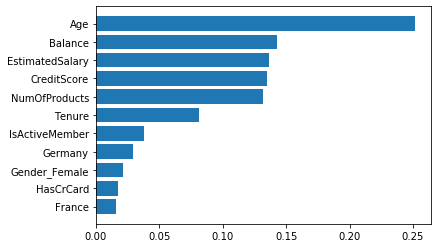

In [23]:
bml.pre.print_feature_importances()

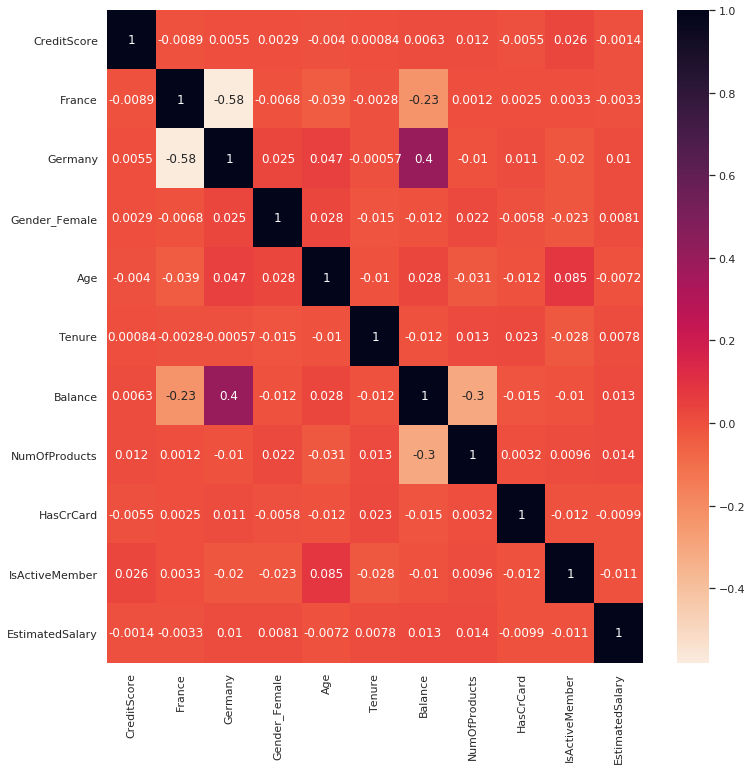

In [24]:
bml.pre.print_feature_correlation()


Logistic_Regression Model : 

  Total time : 18.759 and n_iter : 98
Best parameters:  {'C': 0.0955361631898295, 'penalty': 'l1'}
Mean cross-validated score of the best_estimator:  0.501


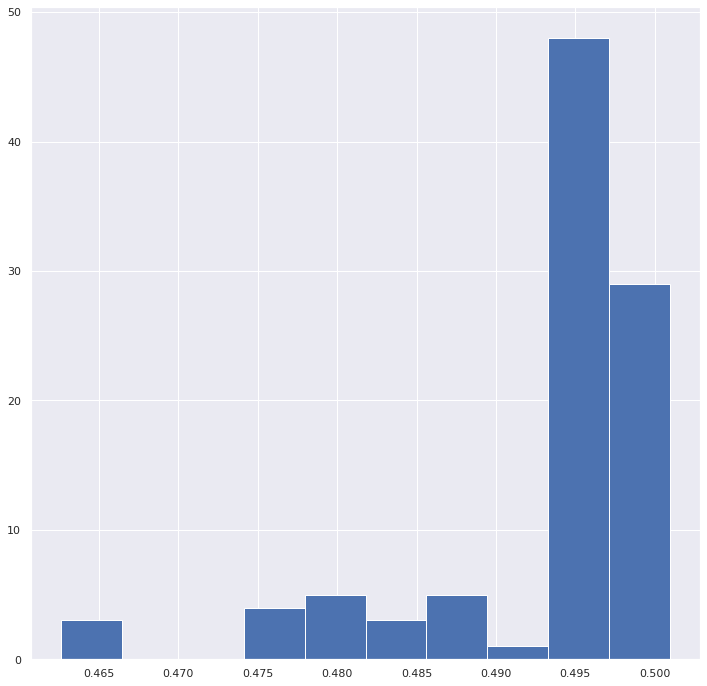

Time search : 19.113355512

Cross validation score :

roc_auc = 0.7717
precision 1 = 0.388
recall 1 = 0.6883
f1 score 1 = 0.4962

              precision    recall  f1-score   support

           0      0.901     0.722     0.802      6370
           1      0.388     0.688     0.496      1630

    accuracy                          0.715      8000
   macro avg      0.644     0.705     0.649      8000
weighted avg      0.796     0.715     0.739      8000

Time validation : 0.21764442700003883

Random_Forest Model : 

  Total time : 8.762 and n_iter : 1
Best parameters:  {'max_depth': 15, 'max_samples': 0.7098085308591002, 'min_samples_split': 3, 'n_estimators': 204}
Mean cross-validated score of the best_estimator:  0.5854


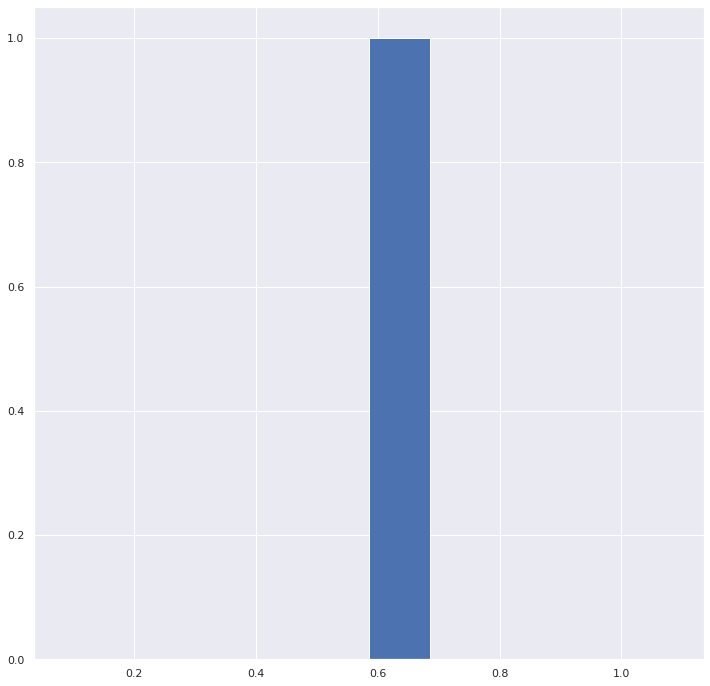

Time search : 9.109679968000023

Cross validation score :

roc_auc = 0.8591
precision 1 = 0.7346
recall 1 = 0.489
f1 score 1 = 0.5871

              precision    recall  f1-score   support

           0      0.880     0.955     0.916      6370
           1      0.735     0.489     0.587      1630

    accuracy                          0.860      8000
   macro avg      0.807     0.722     0.751      8000
weighted avg      0.850     0.860     0.849      8000

Time validation : 7.148025373999985

LightGBM Model : 

  Total time : 16.362 and n_iter : 9
Best parameters:  {'bagging_fraction': 0.8654938671463129, 'learning_rate': 0.15354594832860605, 'n_estimators': 146, 'num_leaves': 54}
Mean cross-validated score of the best_estimator:  0.5847


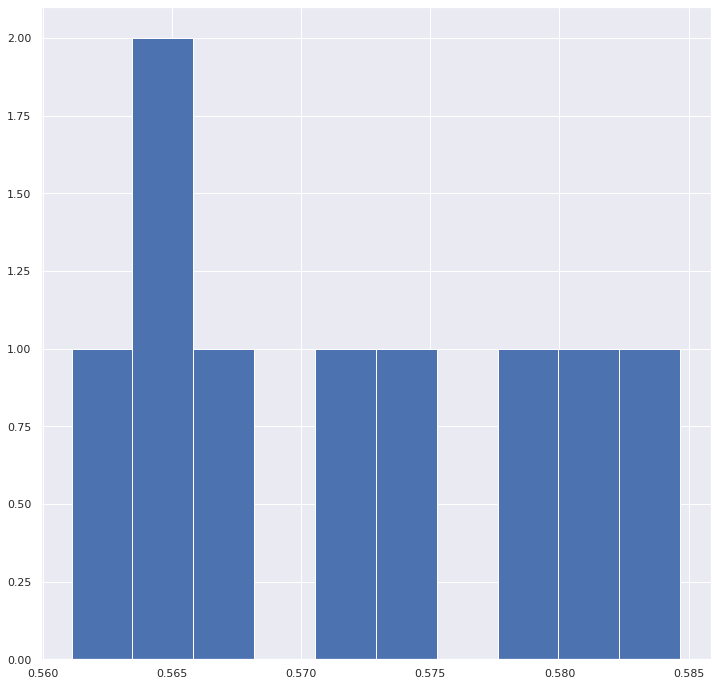

Time search : 16.717973209000036

Cross validation score :

roc_auc = 0.8391
precision 1 = 0.5912
recall 1 = 0.5883
f1 score 1 = 0.5898

              precision    recall  f1-score   support

           0      0.895     0.896     0.895      6370
           1      0.591     0.588     0.590      1630

    accuracy                          0.833      8000
   macro avg      0.743     0.742     0.743      8000
weighted avg      0.833     0.833     0.833      8000

Time validation : 1.2614305820000027

XGBoost Model : 

  Total time : 14.111 and n_iter : 4
Best parameters:  {'learning_rate': 0.29180185937419134, 'max_depth': 3, 'n_estimators': 144, 'subsample': 0.6658696843435157}
Mean cross-validated score of the best_estimator:  0.5836


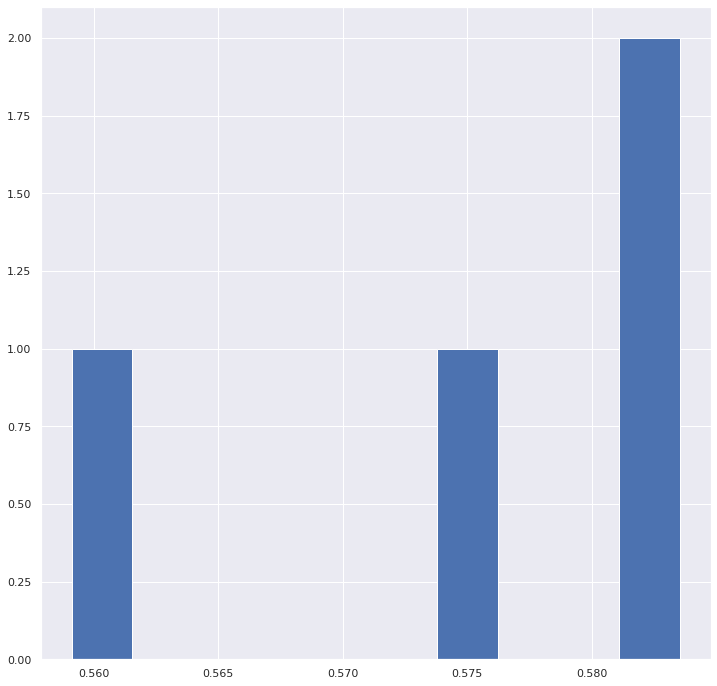

Time search : 14.443908179999994

Cross validation score :

roc_auc = 0.8558
precision 1 = 0.725
recall 1 = 0.5031
f1 score 1 = 0.594

              precision    recall  f1-score   support

           0      0.882     0.951     0.915      6370
           1      0.725     0.503     0.594      1630

    accuracy                          0.860      8000
   macro avg      0.804     0.727     0.755      8000
weighted avg      0.850     0.860     0.850      8000

Time validation : 1.9222653159999936

CatBoost Model : 

  Total time : 9.627 and n_iter : 4
Best parameters:  {'depth': 6, 'iterations': 179, 'learning_rate': 0.14720911650060836, 'subsample': 0.6703019095256506}
Mean cross-validated score of the best_estimator:  0.6114


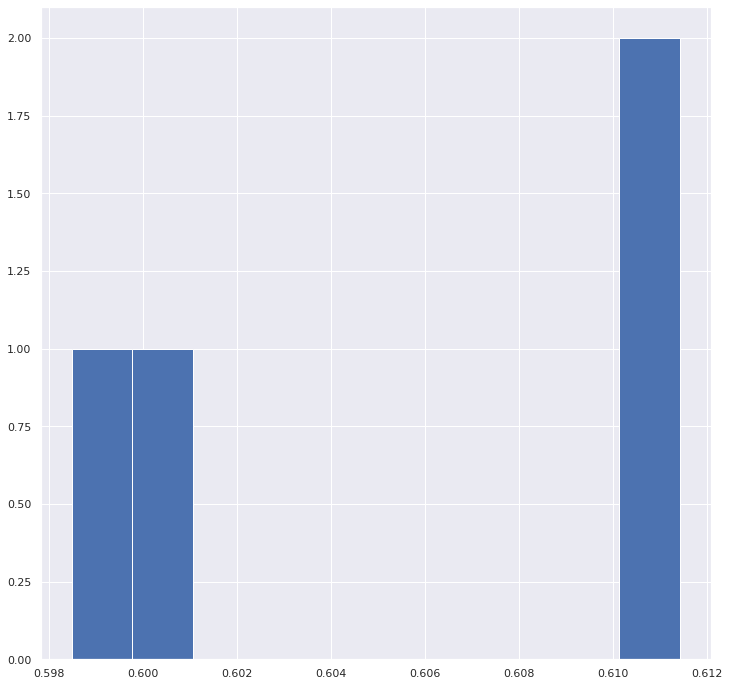

Time search : 9.99020711999998

Cross validation score :

roc_auc = 0.8658
precision 1 = 0.526
recall 1 = 0.7374
f1 score 1 = 0.614

              precision    recall  f1-score   support

           0      0.925     0.830     0.875      6370
           1      0.526     0.737     0.614      1630

    accuracy                          0.811      8000
   macro avg      0.726     0.784     0.745      8000
weighted avg      0.844     0.811     0.822      8000

Time validation : 3.3439864339999303

SimpleNeuralNetwork Model : 

{'hidden_units': [107, 96.16245614421993], 'learning_rate': 0.01, 'dropout_rate': 0.08556760879741826}
oof_val score
f1
Metric
0.5985645933014355
  1%|          | 1/100 [01:02<1:43:18, 62.61s/trial, best loss: -0.5985645933014355]
Best parameters:  {'dropout_rate': 0.08556760879741826, 'hidden_unit_1': 107, 'hidden_unit_2': 96.16245614421993, 'hidden_unit_3': 0, 'learning_rate': 0.01}
Mean cross-validated score of the best_estimator:  0.5986

Epoch 00008: ReduceLROnPl

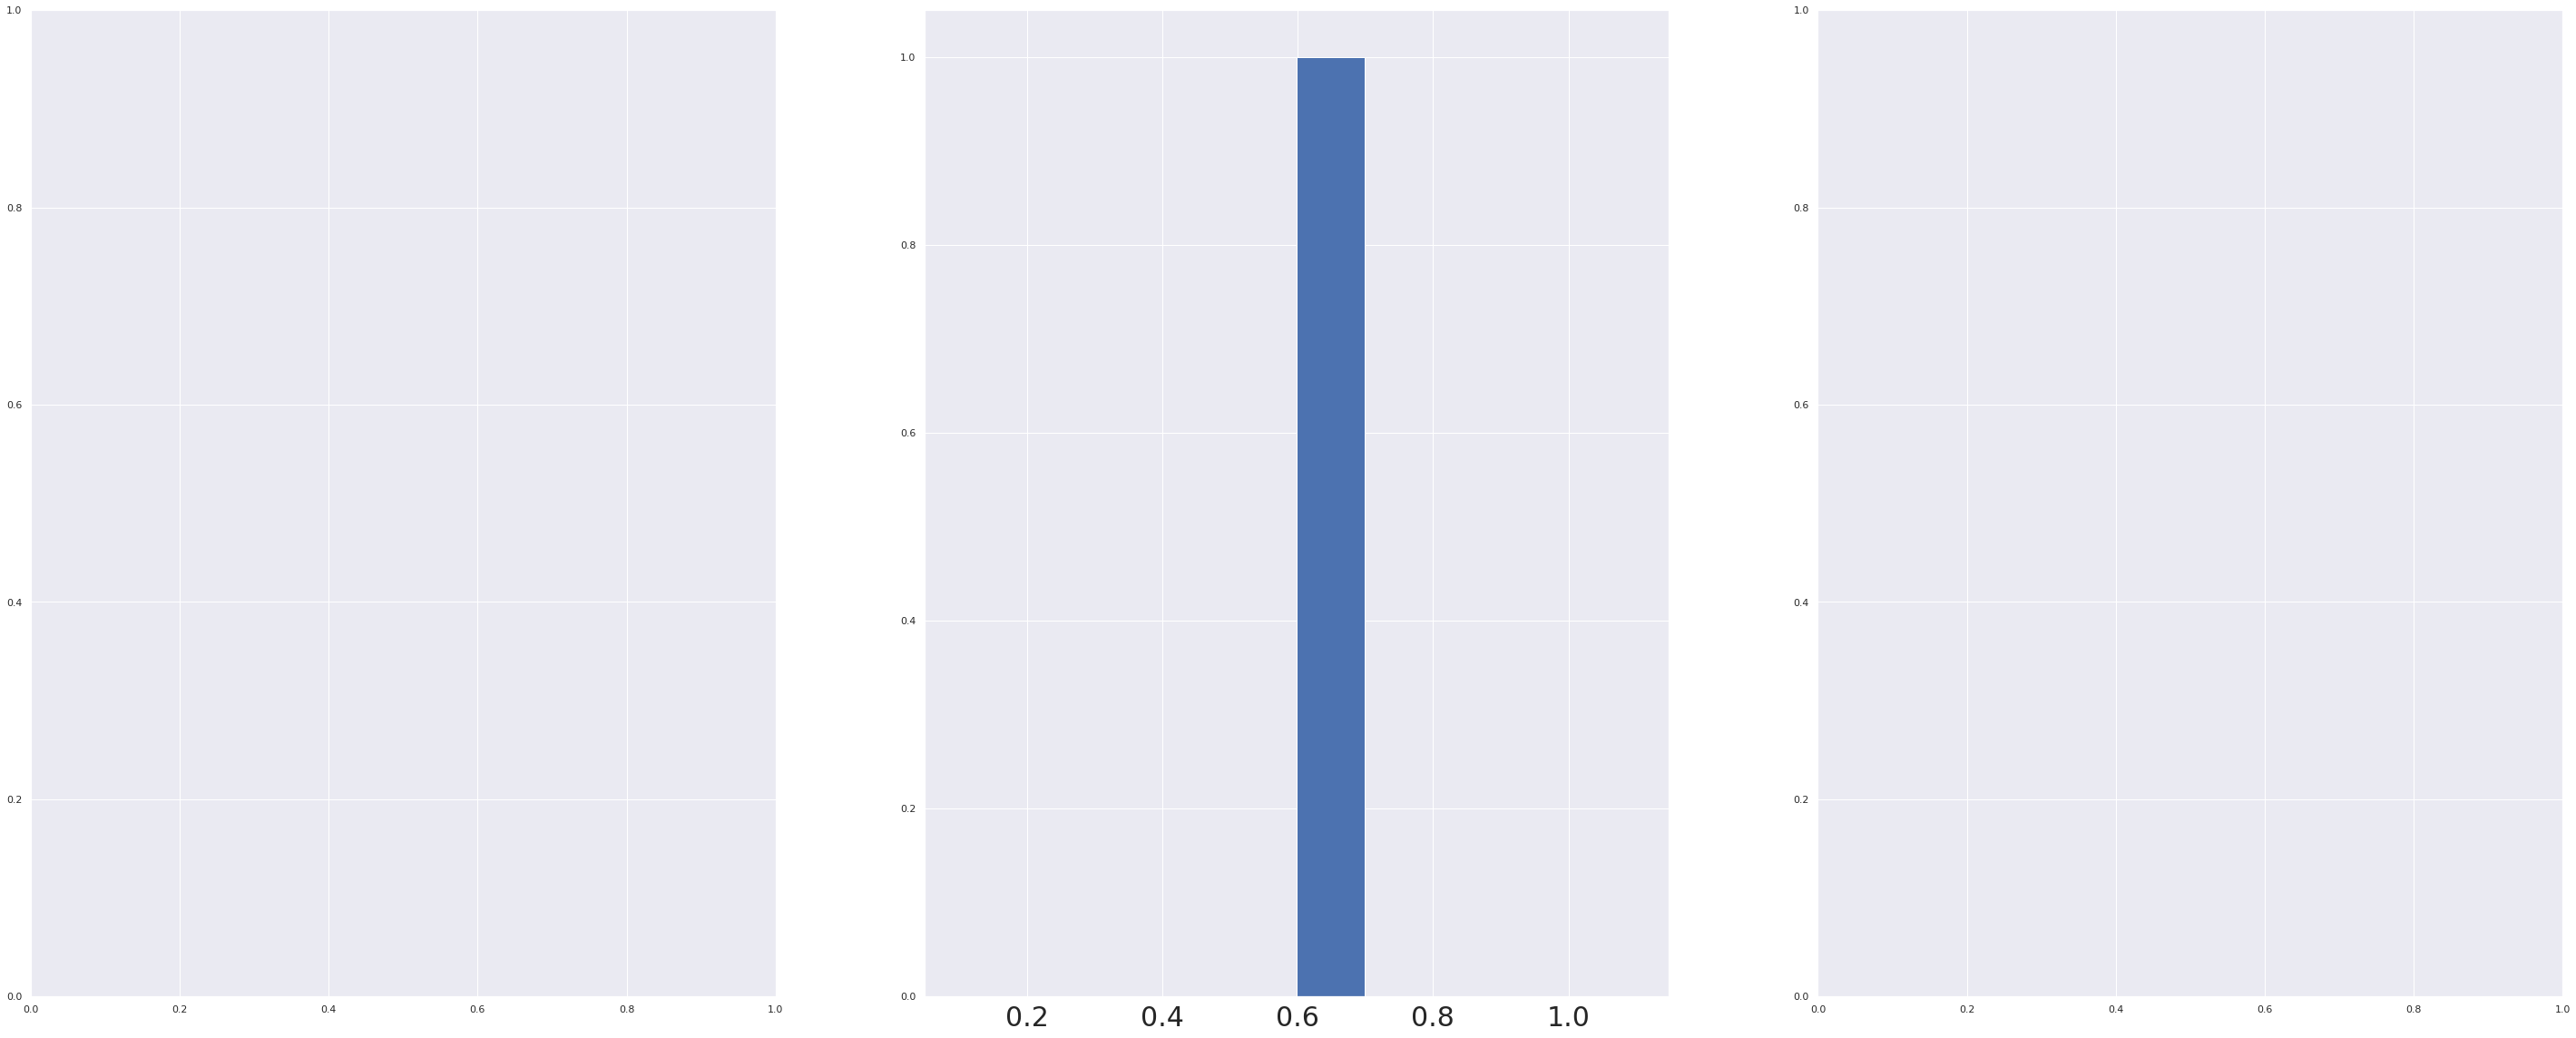

Time search : 78.36028227899999
Train on 6400 samples, validate on 1600 samples
Epoch 1/50
6400/6400 [==============================] - 2s 274us/sample - loss: 0.6026 - accuracy: 0.6928 - val_loss: 0.5670 - val_accuracy: 0.7081
Epoch 2/50
6400/6400 [==============================] - 1s 155us/sample - loss: 0.5334 - accuracy: 0.7355 - val_loss: 0.5329 - val_accuracy: 0.7094
Epoch 3/50
6400/6400 [==============================] - 1s 149us/sample - loss: 0.5245 - accuracy: 0.7392 - val_loss: 0.5004 - val_accuracy: 0.7387
Epoch 4/50
6400/6400 [==============================] - 1s 147us/sample - loss: 0.5120 - accuracy: 0.7483 - val_loss: 0.4970 - val_accuracy: 0.7525
Epoch 5/50
6400/6400 [==============================] - 1s 150us/sample - loss: 0.5151 - accuracy: 0.7536 - val_loss: 0.4883 - val_accuracy: 0.8044
Epoch 6/50
6400/6400 [==============================] - 1s 153us/sample - loss: 0.5080 - accuracy: 0.7536 - val_loss: 0.4831 - val_accuracy: 0.7856
Epoch 7/50
6400/6400 [==========

In [25]:
%%time
bml.train()

# Ensemble

In [26]:
%%time
bml.ensemble()


Stacking Model : 


Cross validation score :

roc_auc = 0.8423
precision 1 = 0.7325
recall 1 = 0.4687
f1 score 1 = 0.5716

              precision    recall  f1-score   support

           0      0.876     0.956     0.914      6370
           1      0.733     0.469     0.572      1630

    accuracy                          0.857      8000
   macro avg      0.804     0.712     0.743      8000
weighted avg      0.846     0.857     0.844      8000


Blend Model : 


Cross validation score :

roc_auc = 0.8662
precision 1 = 0.6229
recall 1 = 0.6264
f1 score 1 = 0.6247

              precision    recall  f1-score   support

           0      0.904     0.903     0.904      6370
           1      0.623     0.626     0.625      1630

    accuracy                          0.847      8000
   macro avg      0.764     0.765     0.764      8000
weighted avg      0.847     0.847     0.847      8000

CPU times: user 1min 58s, sys: 6.85 s, total: 2min 4s
Wall time: 1min 20s


# Leaderboard (Validation score)

In [27]:
bml.get_leaderboard(sort_by = sort_leaderboard, dataset = 'val')

,name,accuracy_val,recall_val,precision_val,f1_val,roc_auc_val
7,BlendModel,0.8466,0.6264,0.6229,0.6247,0.8662
4,CatBoost,0.8111,0.7374,0.5260,0.6140,0.8658
5,SimpleNeuralNetwork,0.7972,0.7564,0.5016,0.6032,0.8632
3,XGBoost,0.8599,0.5031,0.7250,0.5940,0.8558
2,LightGBM,0.8332,0.5883,0.5912,0.5898,0.8391
1,Random_Forest,0.8599,0.4890,0.7346,0.5871,0.8591
6,Stacking,0.8569,0.4687,0.7325,0.5716,0.8423
0,Logistic_Regression,0.7153,0.6883,0.3880,0.4962,0.7717


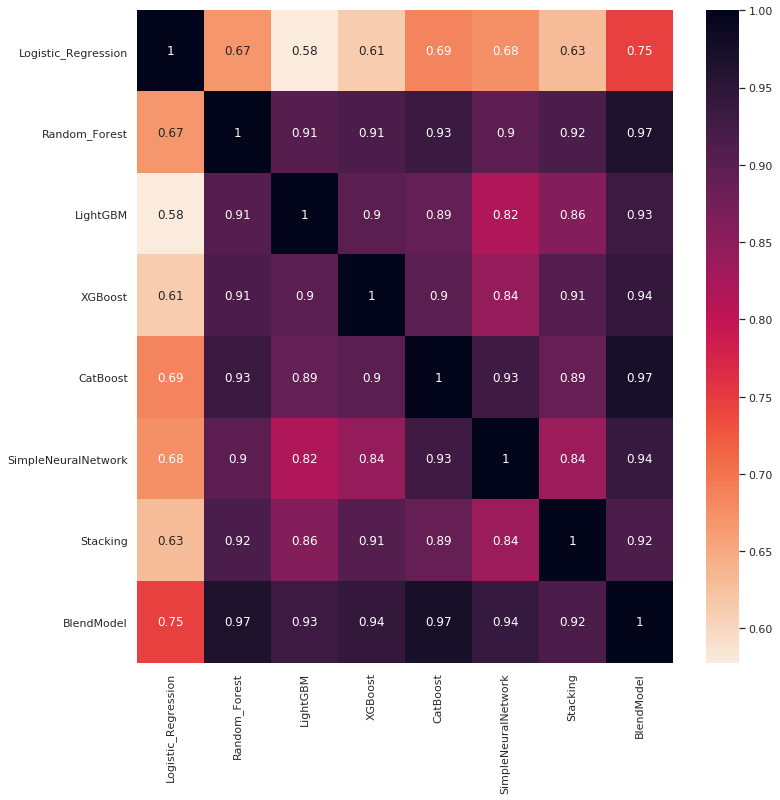

In [28]:
bml.correlation_models()

In [29]:
val_data = bml.Y_train
for name in bml.models.keys():
    val_data[name] = bml.models[name].info_scores['oof_val']
val_data.to_csv('oof_val.csv', index=False)
val_data

,Exited,Logistic_Regression,Random_Forest,LightGBM,XGBoost,CatBoost,SimpleNeuralNetwork,Stacking,BlendModel
522,0,0.227904,0.091136,0.053773,0.045612,0.118338,0.106667,0.05,0.107238
5667,0,0.232173,0.035461,0.007033,0.009831,0.038728,0.026731,0.04,0.058326
4030,0,0.367540,0.355526,0.417744,0.279566,0.588354,0.727761,0.10,0.456082
3198,0,0.228396,0.072431,0.008022,0.021890,0.110459,0.154555,0.09,0.099292
2902,0,0.287240,0.064187,0.019356,0.095150,0.114466,0.176683,0.04,0.126180
...,...,...,...,...,...,...,...,...,...
9067,0,0.606366,0.130968,0.009842,0.018715,0.124158,0.333476,0.11,0.203921
9617,0,0.684204,0.098210,0.149311,0.057919,0.258672,0.187870,0.03,0.239364
5152,0,0.182948,0.014652,0.000910,0.007473,0.026153,0.010201,0.00,0.040390
3322,0,0.396451,0.233973,0.335175,0.148097,0.435201,0.555626,0.26,0.350754


In [30]:
df_all_results = bml.get_df_all_results()
df_all_results.to_csv('df_all_results.csv', index=False)
df_all_results.head()

,mean_fit_time,params,mean_test_score,std_test_score,model
0,0.036171,"{'C': 0.0955361631898295, 'penalty': 'l1'}",0.500953,0.013064,Logistic_Regression
1,0.036166,"{'C': 0.1476183778237683, 'penalty': 'l1'}",0.500814,0.013542,Logistic_Regression
2,0.035913,"{'C': 0.06998878688304569, 'penalty': 'l1'}",0.500708,0.013683,Logistic_Regression
3,0.036805,"{'C': 0.11511395776892147, 'penalty': 'l1'}",0.500704,0.013210,Logistic_Regression
4,0.036343,"{'C': 0.12219933192365862, 'penalty': 'l1'}",0.500603,0.013363,Logistic_Regression


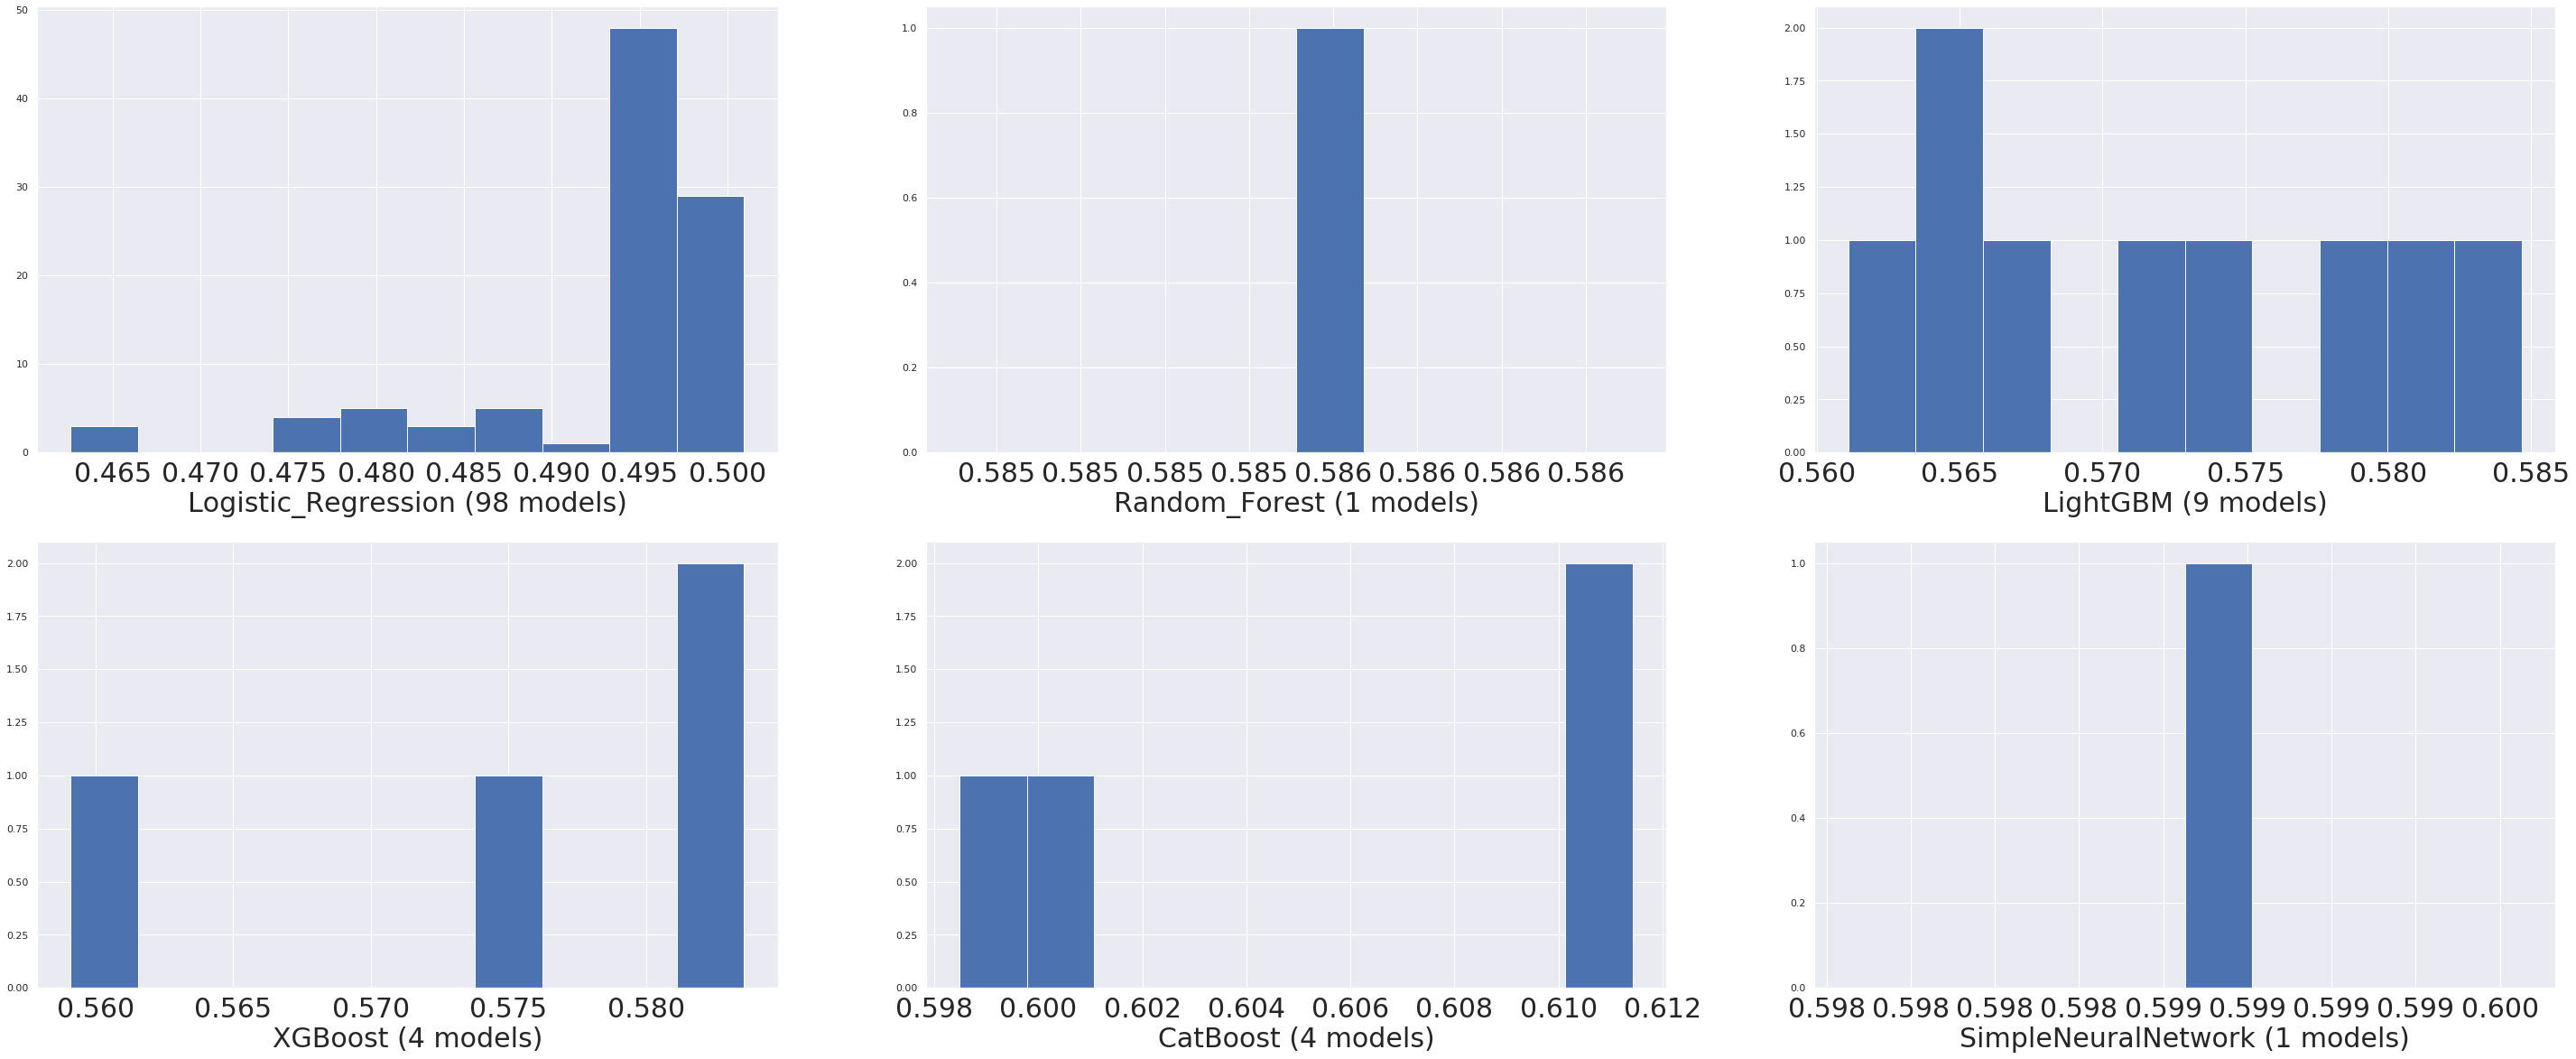

In [31]:
bml.show_distribution_scores()

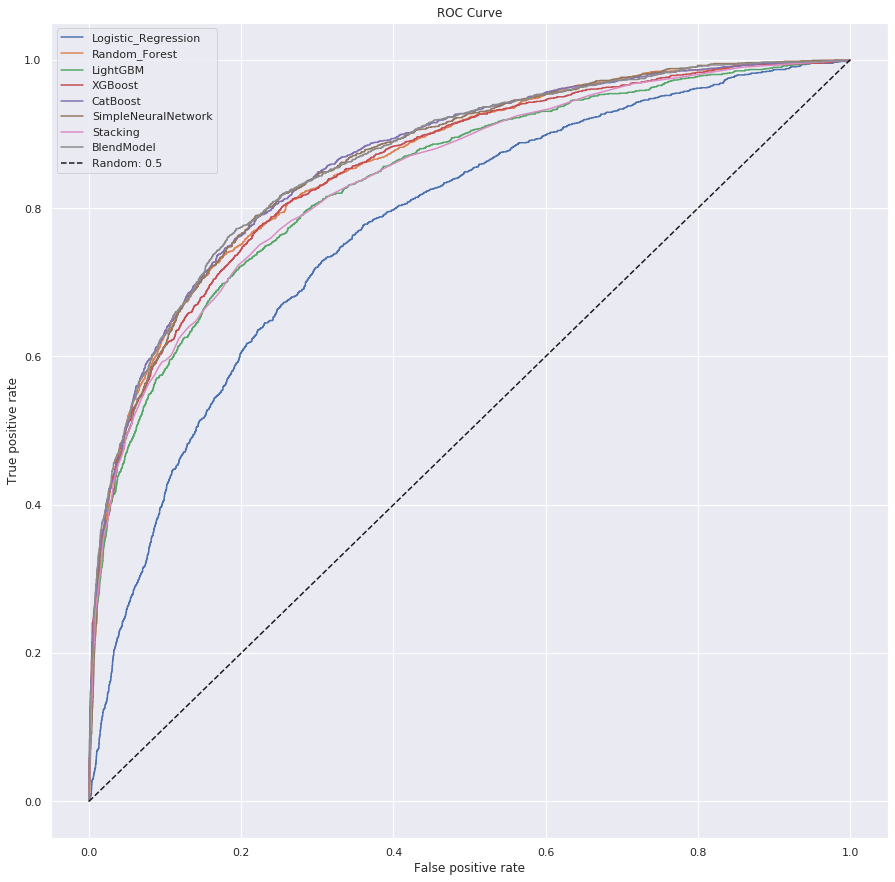

In [32]:
if bml.objective == 'binary_proba':
    bml.get_roc_curves()

In [33]:
on_test_data = True
bml.leader_predict(on_test_data)    # or bml.leader_predict(aml.X_test, aml.Y_test)

In [34]:
prediction = bml.dataframe_predictions
prediction.to_csv('prediction.csv', index=False)
prediction

,y_true,Logistic_Regression,Random_Forest,LightGBM,XGBoost,CatBoost,SimpleNeuralNetwork,Stacking,BlendModel
0,1,0.556,0.707,1.000,0.992,0.964,1.000,0.94,0.870
1,0,0.434,0.041,0.002,0.020,0.037,0.078,0.02,0.102
2,0,0.130,0.039,0.020,0.019,0.072,0.037,0.07,0.053
3,1,0.547,0.278,0.451,0.378,0.607,0.667,0.31,0.488
4,0,0.657,0.545,0.445,0.517,0.820,0.778,0.72,0.627
...,...,...,...,...,...,...,...,...,...
1995,1,0.842,0.860,0.763,0.776,0.931,0.929,0.67,0.850
1996,0,0.349,0.003,0.039,0.018,0.104,0.085,0.00,0.100
1997,0,0.181,0.107,0.015,0.011,0.083,0.266,0.02,0.111
1998,0,0.294,0.102,0.006,0.074,0.137,0.241,0.06,0.142


In [35]:
prediction.corr()

,y_true,Logistic_Regression,Random_Forest,LightGBM,XGBoost,CatBoost,SimpleNeuralNetwork,Stacking,BlendModel
y_true,1.000000,0.371030,0.588287,0.547017,0.582590,0.561009,0.542261,0.571815,0.582638
Logistic_Regression,0.371030,1.000000,0.642301,0.567788,0.597755,0.667608,0.709680,0.604152,0.739863
Random_Forest,0.588287,0.642301,1.000000,0.908132,0.917661,0.935612,0.893532,0.915535,0.965333
LightGBM,0.547017,0.567788,0.908132,1.000000,0.899483,0.889019,0.807758,0.870026,0.931400
XGBoost,0.582590,0.597755,0.917661,0.899483,1.000000,0.900296,0.845896,0.901975,0.942716
CatBoost,0.561009,0.667608,0.935612,0.889019,0.900296,1.000000,0.933473,0.898823,0.972130
SimpleNeuralNetwork,0.542261,0.709680,0.893532,0.807758,0.845896,0.933473,1.000000,0.844224,0.943628
Stacking,0.571815,0.604152,0.915535,0.870026,0.901975,0.898823,0.844224,1.000000,0.918877
BlendModel,0.582638,0.739863,0.965333,0.931400,0.942716,0.972130,0.943628,0.918877,1.000000


In [36]:
leaderboard_test = bml.get_leaderboard(sort_by = sort_leaderboard, dataset = 'test')
leaderboard_test.to_csv('leaderboard_test.csv', index=False)
leaderboard_test

,name,accuracy_test,recall_test,precision_test,f1_test,roc_auc_test
7,BlendModel,0.8465,0.6093,0.6263,0.6177,0.8535
1,Random_Forest,0.8605,0.5086,0.7238,0.5974,0.8494
4,CatBoost,0.7970,0.7224,0.5009,0.5915,0.8550
6,Stacking,0.8555,0.5135,0.6967,0.5912,0.8348
2,LightGBM,0.8345,0.5676,0.5984,0.5826,0.8370
3,XGBoost,0.8555,0.4914,0.7092,0.5806,0.8420
5,SimpleNeuralNetwork,0.7650,0.7346,0.4523,0.5599,0.8491
0,Logistic_Regression,0.6995,0.6904,0.3717,0.4832,0.7573


In [37]:
leaderboard_val = bml.get_leaderboard(sort_by = sort_leaderboard, dataset = 'val')
leaderboard_val.to_csv('leaderboard_val.csv', index=False)
leaderboard_val

,name,accuracy_val,recall_val,precision_val,f1_val,roc_auc_val
7,BlendModel,0.8466,0.6264,0.6229,0.6247,0.8662
4,CatBoost,0.8111,0.7374,0.5260,0.6140,0.8658
5,SimpleNeuralNetwork,0.7972,0.7564,0.5016,0.6032,0.8632
3,XGBoost,0.8599,0.5031,0.7250,0.5940,0.8558
2,LightGBM,0.8332,0.5883,0.5912,0.5898,0.8391
1,Random_Forest,0.8599,0.4890,0.7346,0.5871,0.8591
6,Stacking,0.8569,0.4687,0.7325,0.5716,0.8423
0,Logistic_Regression,0.7153,0.6883,0.3880,0.4962,0.7717
